# Выбор локации для скважины

# Оглавление

[Описание пректа](#data) <br>
1. [Загрузка и подготовка данных](#1)<br>
2. [Обучение и проверка модели](#2)<br>
3. [Подготовка к расчёту прибыли](#3)<br>
4. [Расчёт прибыли и рисков](#4)<br>
5. [Выводы](#end)<br>

<a id='data'></a>
## 📣 Описание пректа

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. <br>
Шаги для выбора локации обычно такие:
1. В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
2. Строят модель для предсказания объёма запасов в новых скважинах;
3. Выбирают скважины с самыми высокими оценками значений;
4. Определяют регион с максимальной суммарной прибылью отобранных скважин.

__Условия задачи:__
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

<br>

_Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны._ <br> <br>

__Цели проекта:__ <br>
🚩 Построить модель для определения региона, где добыча принесёт наибольшую прибыль. <br>
🚩 Проанализировать возможную прибыль и риски техникой Bootstrap. <br>
<br>

__🧩 Описание данных:__<br>
Данные геологоразведки трёх регионов находятся в файлах:<br>
`geo_data_0.csv`<br>
`geo_data_1.csv`<br>
`geo_data_2.csv`<br>
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

_Импорт необходимых библиотек, закрепление констант_

In [1]:
const_state = 12345

from numpy.random import RandomState
state = RandomState(const_state) 

from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st

---
<a id='1'></a>
## Загрузка и подготовка данных

### Откроем данные и предварительно изучим их

In [2]:
df_region_0 = pd.read_csv('.../datasets/geo_data_0.csv')
df_region_1 = pd.read_csv('.../datasets/geo_data_1.csv')
df_region_2 = pd.read_csv('.../datasets/geo_data_2.csv')

📝 Для удобства и автоматизации создадим список с элементами DataFrame

In [3]:
df_list = [df_region_0, df_region_1, df_region_2]

In [4]:
for i in range(len(df_list)):
    print('-------------------------------------------')
    print('DataFrame регион', i)
    display(df_list[i].sample(random_state=const_state))
    display(df_list[i].info())

-------------------------------------------
DataFrame регион 0


,id,f0,f1,f2,product
71751,7Z2gx,0.94897,-0.057547,2.095727,10.038645


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

-------------------------------------------
DataFrame регион 1


,id,f0,f1,f2,product
71751,aTbUt,-0.371866,-1.862494,3.00221,80.859783


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

-------------------------------------------
DataFrame регион 2


,id,f0,f1,f2,product
71751,DMlgl,-1.444717,-3.861599,2.225805,61.212375


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

### Подготовка данных

📝 В нашем случае подготовка данных представляет из себя разбивку датафреймов на <br>
- 📖 обучающую выборку
- 📘 валидационную выборку

и

- 🧩 Признаки (`id`, `f0`, `f1`, `f2`)
- 🎯 Целевой признак (`product`)

📝 Для начала проведем разбивку на обучающие выборки и валидационные <br>
Разбивка будет происходить в слудющем соотношении: <br>
- обучающая выборку - 75%
- валидационная выборку - 25%

Для этого создадим 2 списка

In [5]:
train_list = []
valid_list = []

for region in df_list:
    train_per, valid_per = train_test_split(region, 
                                            test_size=0.25, 
                                            random_state=const_state)
    train_list.append(train_per)
    valid_list.append(valid_per)
    
train_list = pd.Series(train_list)
valid_list = pd.Series(valid_list)

📝 Создадим списоки с разделением по признакам и целевому признаку следующего формата <br> 
`[[id, признаки, целевой признак df0],`<br>
`[id, признаки, целевой признак df1],`<br>
`[id, признаки, целевой признак df2]]`<br>

In [6]:
feat_targ_train = []
feat_targ_valid = []

for region in train_list:
    per_list = []
    per_list.append(region['id'])
    per_list.append(region.drop(['product', 'id'], axis=1))
    per_list.append(region['product'])
    feat_targ_train.append(pd.Series(per_list))
for region in valid_list:
    per_list = []
    per_list.append(region['id'])
    per_list.append(region.drop(['product', 'id'], axis=1))
    per_list.append(region['product'])
    feat_targ_valid.append(pd.Series(per_list))

📍 __Выводы__<br>
> ✅ Данные в предобработке не нуждаются <br>
> ✅ Датафреймы были разделены по (признакам и целевому признаку) и (выборки на валидационную и обучающую)
---

<a id='2'></a>
## Обучение и проверка модели

📝 Произведем обучение в отдельности для каждого региона, посчитаем 

In [7]:
predictions_valid = []
model = LinearRegression()

prediction_df_mean_rmse = pd.DataFrame(index={'0_region', 
                                              '1_region', 
                                              '2_region'},
                                       columns={'rmse', 
                                                'mean'})

for region in range(len(feat_targ_train)):
    model.fit(feat_targ_train[region][1], feat_targ_train[region][2])
    predictions = model.predict(feat_targ_valid[region][1])
    predictions = pd.Series(predictions)
    predictions.index = feat_targ_valid[region][1].index
    predictions_valid.append(predictions)
    prediction_df_mean_rmse.loc[(str(region) + '_region'), 'rmse'] = mean_squared_error(feat_targ_valid[region][2],
                                                                                   predictions, 
                                                                                   squared=False)
    prediction_df_mean_rmse.loc[(str(region) + '_region'), 'mean'] = predictions.mean()
    
prediction_df_mean_rmse

,mean,rmse
2_region,94.965,40.0297
1_region,68.7285,0.893099
0_region,92.5926,37.5794


📝 Результат на валидационной выборке линейной регрессии показал, что: _чем выше среднее значение предсказанного объема месторождения, тем больше ошибка и наоборот_ <br> В регтонах регион 2 и 0 модель предсказала достаточно большой средний объем месторождения, однако, они имеют тостаточно большую RMSE-метрику. Регион 1 имеет меньший средний объем месторождений, однако средняя квадратическая ошибка меньше единицы. <br>
📝 Для того, чтобы понять почему так выходит попробуем построить графики по объемам месторождений.

In [8]:
def do_2plots(s1, s2, title):
    sns.kdeplot(s1, 
                shade=True, 
                color="skyblue",
                alpha=.3)
    sns.kdeplot(s2, 
                shade=True, 
                color="lightcoral",
                alpha=.3)
    plt.ylabel('Плотность')
    plt.xlabel('Объем')
    plt.title(title)
    
    name_of_colors = {
    'Целевой признак': 'skyblue',
    'Предсказания': 'lightcoral'
    }
    patches = [matplotlib.patches.Patch(color=v, label=k) for k,v in name_of_colors.items()]
    plt.legend(handles=patches)

__📈 Регионы__

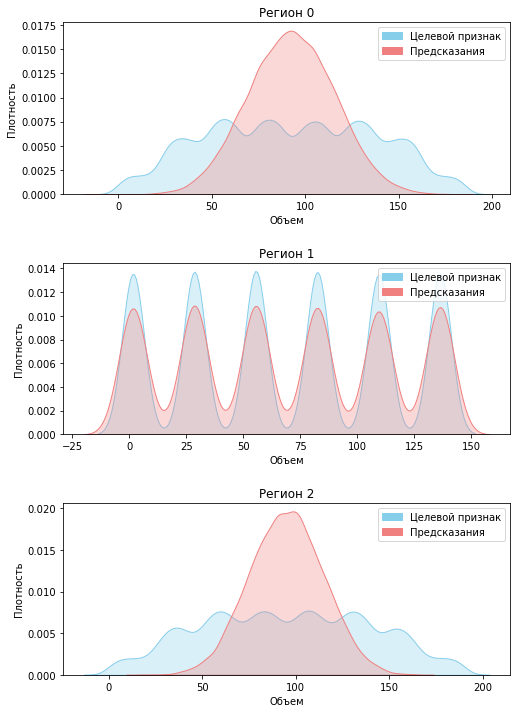

In [9]:
plt.figure(figsize=(8, 12))
plt.subplots_adjust(hspace=0.4)

plt.subplot(3,1,1)
do_2plots(df_region_0['product'], predictions_valid[0], 'Регион 0')
plt.subplot(3,1,2)
do_2plots(df_region_1['product'], predictions_valid[1], 'Регион 1')
plt.subplot(3,1,3)
do_2plots(df_region_2['product'], predictions_valid[2], 'Регион 2')

📝 Как мы видим, в регионах 0 и 2 графики целевого признака и предсказаний достаточно сильно отличаются. Предсказания являются нормальным распределениям, а целевой признак "усечен". <br>
В регионе 1 же напротив и целевой признак, и предсказания представляют из себя синусоиду и достаточно сильно совпадают.<br>
📝 Изучим корреляцию признаков:

In [10]:
def do_heatmap(data, title):
    sns.heatmap(data,
                annot=True, 
                cmap='Spectral', 
                center=0,
                vmin=-1, 
                vmax=1)
    plt.title(title)

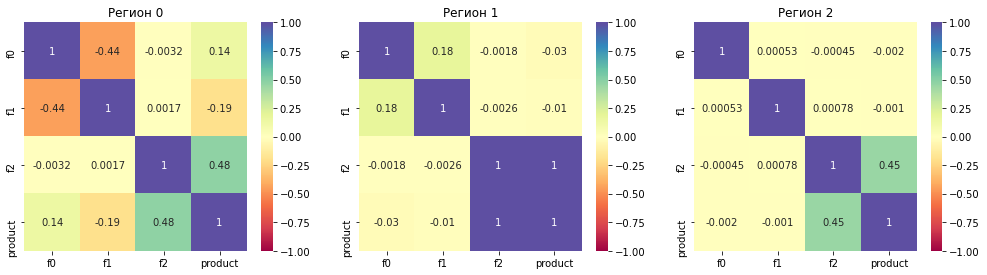

In [11]:
plt.figure(figsize=(17, 4.2))
plt.subplots_adjust(hspace=0.4)

plt.subplot(1,3,1)
do_heatmap(df_list[0].drop('id', axis=1).corr(), 'Регион 0')
plt.subplot(1,3,2)
do_heatmap(df_list[1].drop('id', axis=1).corr(), 'Регион 1')
plt.subplot(1,3,3)
do_heatmap(df_list[2].drop('id', axis=1).corr(), 'Регион 2')

📝 Корреляция показала откуда такая точность модели в регионе 1. Мы видим корреляцию равную 1 между объемом и признаком `f2`, что показывает однозначную зависимость. В остальных регионах такой явной зависимости не наблюдается.

📍 __Выводы__<br>
> ✅ Были обучены модели машинного обучения типа "линейная регрессия" на выборках из 3х регионов <br>
> ✅ Наибольшую точность показала модель обученная на Регионе 1. Дальнейший анализ показал причину таких показателей (корреляция `product & f2` равна 1) <br>
> ✅ Возможно, линейная регрессия не очень хорошо подходит в регионах 0 и 1 и стоит воспользоваться более подходящей моделью

---
<a id='3'></a>
## Подготовка к расчёту прибыли

📝 Присвоим значения необходимым для расчета переменным

In [12]:
number_reservoirs = 500
total_budget = 10**10
total_reservoirs = 200
one_reservoirs_cost = total_budget / total_reservoirs
k_barrel_cost = 45 * 10**4
сonfidence_interval = 0.95

📝 Раcсчитаем достаточный объём сырья для безубыточной разработки новой скважины и сравним с предсказаниями модели.

In [13]:
petrol_vol_enought = one_reservoirs_cost / k_barrel_cost
print('Минимальный объем нефтерождения =', petrol_vol_enought, 'тыс. баррелей')
print('Регион 0: cредний объем месторождения =', predictions_valid[0].mean())
print('Регион 1: cредний объем месторождения =', predictions_valid[1].mean())
print('Регион 2: cредний объем месторождения =', predictions_valid[2].mean())

Минимальный объем нефтерождения = 111.11111111111111 тыс. баррелей
Регион 0: cредний объем месторождения = 92.59256778438008
Регион 1: cредний объем месторождения = 68.7285468954458
Регион 2: cредний объем месторождения = 94.96504596800506


📝 Функция расчета прибыли

In [14]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    total_proceeds = (selected * k_barrel_cost).sum()
    return total_proceeds - total_budget

📍 __Выводы__<br>
> ✅ Переменным были присвоины необходимые значения <br>
> ✅ Средние показатели по запасам нефти в регионам ниже необходимого минимума объема одной скаважины <br>
> ✅ Написана функция расчёта прибыли

---
<a id='4'></a>
## Расчёт прибыли и рисков 

📝 Для начала применим метод Bootstrap для каждого из регионов и создадим ДатаФрэйм из полученных данных.

In [15]:
result = []

for region in range(3):
    values = []
    for i in range(1000):
        target_subsample = feat_targ_valid[region][2].sample(n=number_reservoirs, 
                                                        replace=True, 
                                                        random_state=state)
        probs_subsample = predictions_valid[region].loc[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, total_reservoirs))
    result.append(pd.Series(values))

📝 Теперь посчитаем итоговые параметры по регионам: 
- средняя прибыль
- доверительный интервал
- риск убытков

In [16]:
fital_result_table = pd.DataFrame(columns={'средняя прибыль', 'доверительный интервал', 'риск убытков'},
                                  index={'Регион 0', 'Регион 1', 'Регион 2'})
fital_result_table.loc['Регион 0',        'средняя прибыль'] = result[0].mean()
fital_result_table.loc['Регион 0', 'доверительный интервал'] = (result[0].quantile(0.025), result[0].quantile(0.975))
fital_result_table.loc['Регион 0',           'риск убытков'] = (result[0] < 0).mean()

fital_result_table.loc['Регион 1',        'средняя прибыль'] = result[1].mean()
fital_result_table.loc['Регион 1', 'доверительный интервал'] = (result[1].quantile(0.025), result[1].quantile(0.975))
fital_result_table.loc['Регион 1',           'риск убытков'] = (result[1] < 0).mean()

fital_result_table.loc['Регион 2',        'средняя прибыль'] = result[2].mean()
fital_result_table.loc['Регион 2', 'доверительный интервал'] = (result[2].quantile(0.025), result[2].quantile(0.975))
fital_result_table.loc['Регион 2',         'риск убытков'] = (result[2] < 0).mean()

fital_result_table

,средняя прибыль,доверительный интервал,риск убытков
Регион 2,4.20194e+08,"(-115852609.16000956, 989629939.8445758)",0.062
Регион 1,5.18259e+08,"(128123231.4330864, 953612982.0669086)",0.003
Регион 0,4.25939e+08,"(-102090094.8379384, 947976353.3583671)",0.06


📝 Построим графики

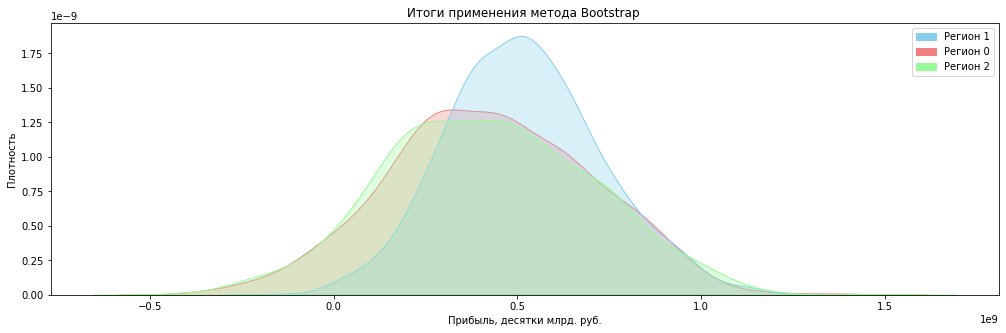

In [17]:
plot_data = [[result[0], "lightcoral"],
             [result[1], "skyblue"],
             [result[2], "palegreen"],]

plt.figure(figsize=(17, 5))
for column, col in plot_data:
    sns.kdeplot(column, 
                shade=True, 
                color=col,
                alpha=.3)
plt.ylabel('Плотность')
plt.xlabel('Прибыль, десятки млрд. руб.')
plt.title('Итоги применения метода Bootstrap ')
    
name_of_colors = {
'Регион 1': 'skyblue',
'Регион 0': 'lightcoral',
'Регион 2': 'palegreen'
}
patches = [matplotlib.patches.Patch(color=v, label=k) for k,v in name_of_colors.items()]
plt.legend(handles=patches)

📍 __Выводы__<br>
> ✅ По каждому региону был проведен Bootstrap <br>
> ✅ Были расчитаны риск убытков, средняя прибыль, доверительный интервал для каждого из 3х регионов <br>

---
<a id='end'></a>
# Выводы

🏁 По итогу проекта можно заключить, что наиболее перспективный вариант это разработка нефтерождений в __регионе 1__, так как результаты исследования показали в данном регионе:
- наивысшая средняя прибыль среди регионов ~ 10 426 млн. руб.
- наилучший показатель вероятности убытков ~ 0.3%
- наиболее узкий 95% доверительный интервал среди регионов, узкий указывает указывает на более точную оценку.